FileChooser(path='\\nas-emotional.fm.ul.pt\eMotional\Exp_4-outdoor_walk\lisbon\sourcedata\data\OE011', filenam…

Loading dataset: Lisbon_Baixa_sub-OE104011_2024-05-13T141238Z...
Reading 0 ... 804052  =      0.000 ...  1608.104 secs...
Attempting to automatically correct eeg timestamps to harp timestamps...
Done.
Dataset: <pluma.schema.Dataset object at 0x0000029A27B8EC50> loaded successfully, and sucessfully calibrated.


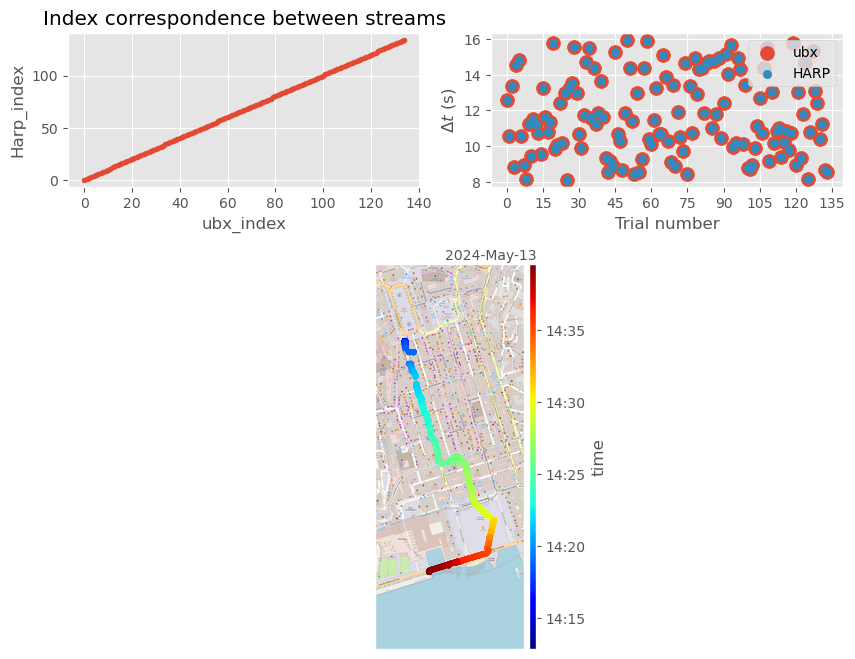

Failed Stream Harp stream from device 		TK, stream GPS_Latitude(227): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_Longitude(228): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_Altitude(229): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_HasFix(232): Input dataframe is empty.


In [2]:
# EEG data analysis
import mne
from mne.io import Raw
from mne.preprocessing import (create_eog_epochs, create_ecg_epochs, corrmap)
from mne.datasets import sample
import numpy as np
import matplotlib.pyplot as plt

# Python API  
from modules import *
from pluma.schema.outdoor import build_schema

# Load data
datapicker = create_datapicker(path=r'Z:\Exp_4-outdoor_walk\lisbon\sourcedata\data\OE011',schema=build_schema)
display(datapicker)

In [3]:
%matplotlib widget
# dir(datapicker.dataset.streams.EEG.data)
raw = datapicker.dataset.streams.EEG.data

<Info | 7 non-empty values
 bads: []
 ch_names: P7, P4, Cz, Pz, P3, P8, O1, O2, T8, F8, C4, F4, Fp2, Fz, C3, F3, ...
 chs: 32 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2024-05-13 14:12:32 UTC
 nchan: 33
 projs: []
 sfreq: 500.0 Hz
>
Using matplotlib as 2D backend.


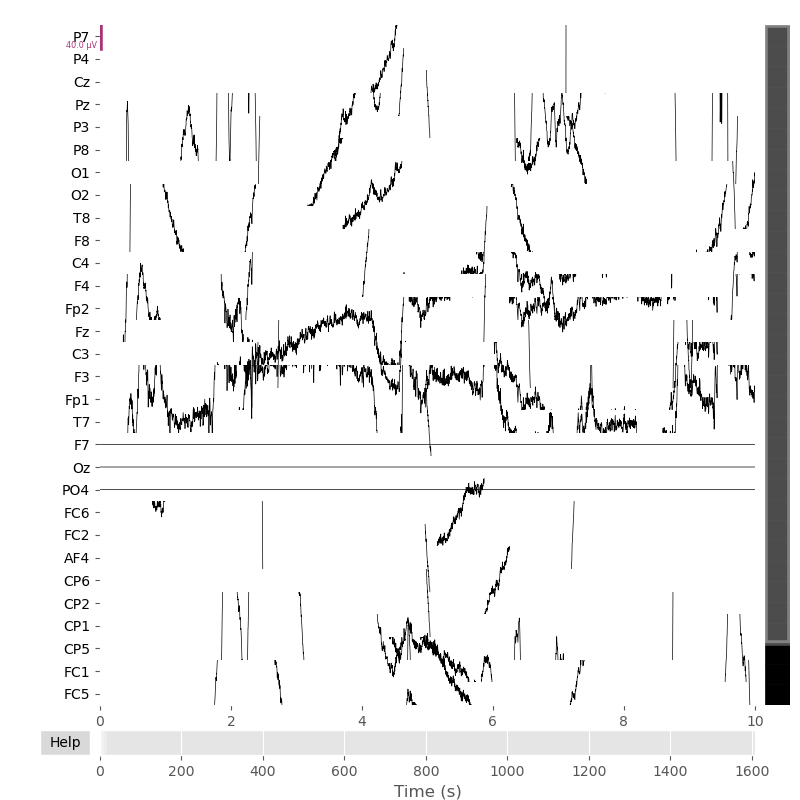

In [4]:
print(raw.info)
raw.plot(n_channels=30, block=True);

In [5]:
# In order to run this script I had to make preload=True in the read_raw_nedf function in nedf.py

# Apply a band-pass filter from 1 Hz to 40 Hz
raw.filter(l_freq=1.0, h_freq=40.0)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


<RawNedf | 20240513151232_OE104011_EXP4.nedf, 33 x 804053 (1608.1 s), ~202.5 MB, data loaded>

In [6]:
# Set standard 10-20 montage
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)


<RawNedf | 20240513151232_OE104011_EXP4.nedf, 33 x 804053 (1608.1 s), ~202.5 MB, data loaded>

In [7]:
# Select only EEG channels
raw_eeg = raw.copy().pick_types(eeg=True)

# Get data from the filtered raw object
data = raw_eeg.get_data()

# Compute standard deviation for each EEG channel
channel_std = np.std(data, axis=1)

# Compute mean and standard deviation across EEG channels
mean_std = np.mean(channel_std)
std_std = np.std(channel_std)

# Set a threshold (e.g., mean + 3*std)
threshold = mean_std + 3 * std_std

# Find EEG channels exceeding the threshold
bad_channels_time = [raw_eeg.ch_names[i] for i in range(len(channel_std)) if channel_std[i] > threshold]

print("Bad EEG channels in time domain:", bad_channels_time)



NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Bad EEG channels in time domain: ['Pz']


In [8]:
# Compute PSDs for all channels
psds_all = raw.compute_psd(fmin=1, fmax=40, n_fft=2048)
psd_data = psds_all.get_data()
freqs_all = psds_all.freqs
total_power = psd_data.sum(axis=1)  # Sum over frequencies for each channel

# Compute mean and std of total power across channels
mean_power = np.mean(total_power)
std_power = np.std(total_power)

# Set a threshold (e.g., mean + 3*std)
threshold_power = mean_power + 3 * std_power

# Find channels exceeding the threshold
bad_channels_freq = [raw.ch_names[i] for i in range(len(total_power)) if total_power[i] > threshold_power]

print("Bad channels in frequency domain:", bad_channels_freq)


Effective window size : 4.096 (s)
Bad channels in frequency domain: ['Pz']


In [9]:
# Combine bad channels from both domains
bad_channels = list(set(bad_channels_time + bad_channels_freq))
print("Total bad channels to remove:", bad_channels)

# Mark bad channels in raw object
raw.info['bads'] = bad_channels

# Remove bad channels
raw = raw.drop_channels(bad_channels)


Total bad channels to remove: ['Pz']


Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 12.4s.


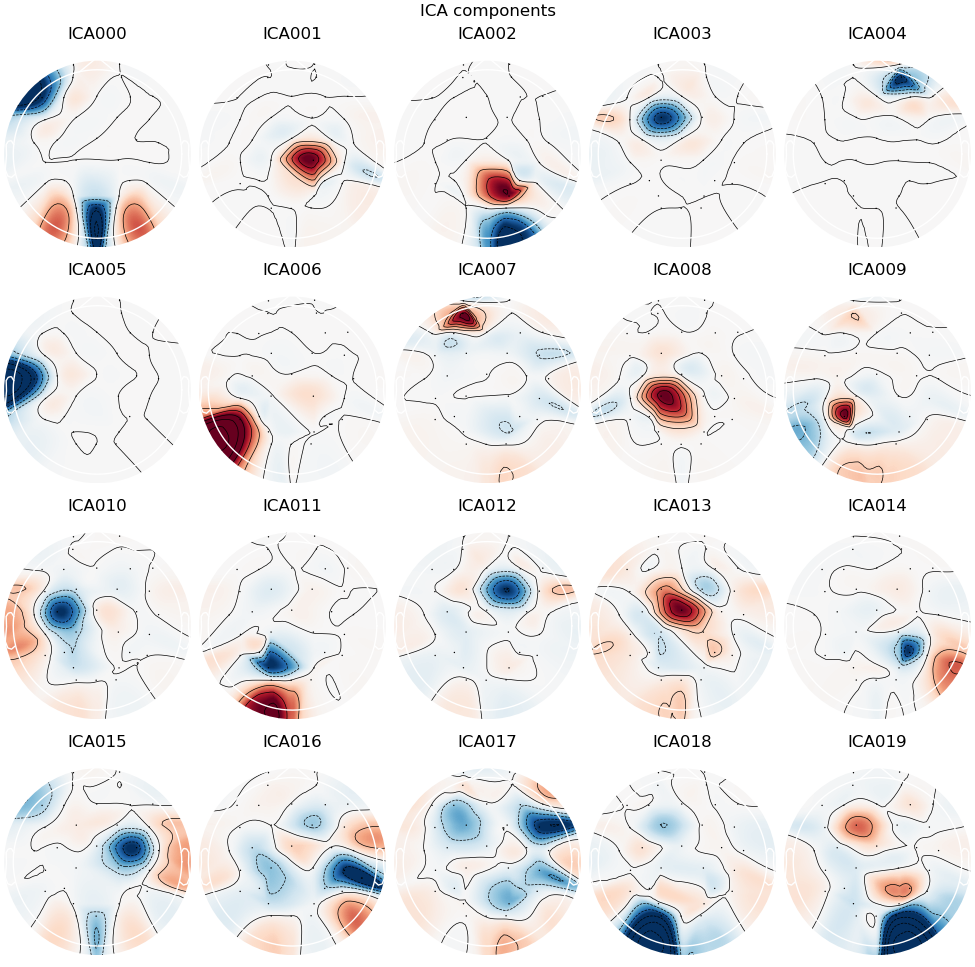

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 31 PCA components


<RawNedf | 20240513151232_OE104011_EXP4.nedf, 32 x 804053 (1608.1 s), ~196.3 MB, data loaded>

In [10]:
# Fit ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter='auto')
ica.fit(raw)

# Plot ICA components to identify artifacts
ica.plot_components()

# Apply ICA to raw data
ica.apply(raw)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


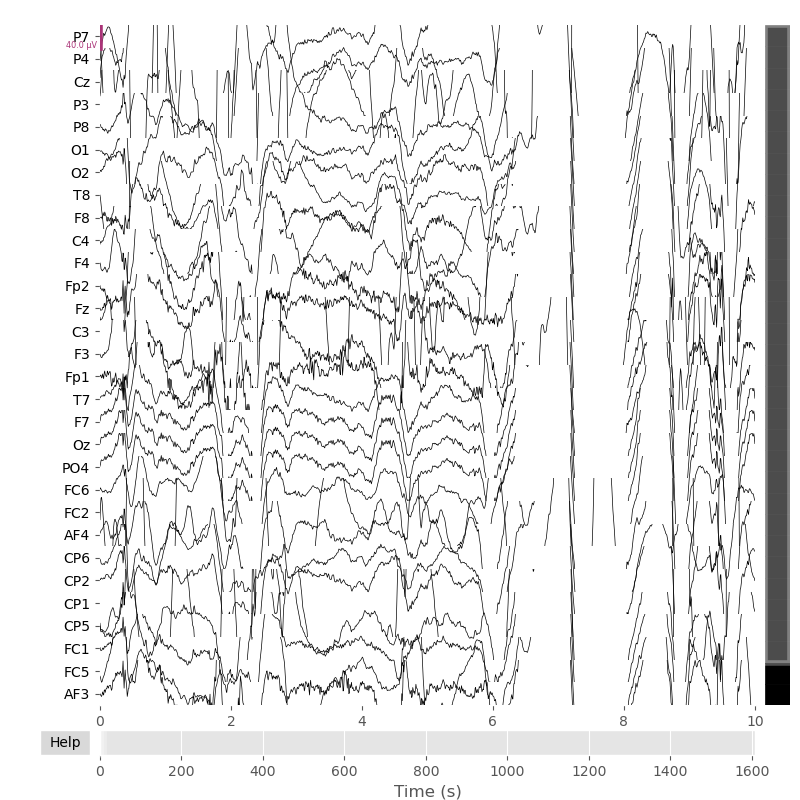

In [13]:
# Set EEG average reference
raw.set_eeg_reference('average', projection=False)
raw.plot(n_channels=30, block=True);

In [14]:
# Find events in the raw data
events = mne.find_events(raw, stim_channel='STI 014')  # Update 'STI 014' if your stim channel is different

# Define event IDs
event_id = {'Baseline_Start': 35001, 'Baseline_End': 35002}

# Print the events to verify
print(events)


154 events found on stim channel STI 014
Event IDs: [    1     2     3     4     5     6     7     8     9    10    11    12
    13    14    15    16    17    18    19    20    21    22    23    24
    25    26    27    28    29    30    31    32    33    34    35    36
    37    38    39    40    41    42    43    44    45    46    47    48
    49    50    51    52    53    54    55    56    57    58    59    60
    61    62    63    64    65    66    67    68    69    70    71    72
    73    74    75    76    77    78    79    80    81    82    83    84
    85    86    87    88    89    90    91    92    93    94    95    96
    97    98    99   100   101   102   103   104   105   106   107   108
   109   110   111   112   113   114   115   116   117   118   119   120
   121   122   123   124   125   126   127   128   129   130   131   132
   133   134   135   136 35001 35002 35003 35004 35005 35006 35101 35102
 35103 35104 35201 35202 35203 35204 35301 35302 35303 35304]
[[  9544  

In [15]:
# Create epochs around the baseline period
baseline_events = events[np.isin(events[:, 2], [35001, 35002])]

# Ensure we have both start and end events
if len(baseline_events) == 2:
    tmin = baseline_events[0, 0] / raw.info['sfreq']
    tmax = baseline_events[1, 0] / raw.info['sfreq']
    baseline_raw = raw.copy().crop(tmin=tmin, tmax=tmax)
else:
    print("Baseline events not found properly.")


Effective window size : 4.096 (s)


Plotting power spectral density (dB=True).


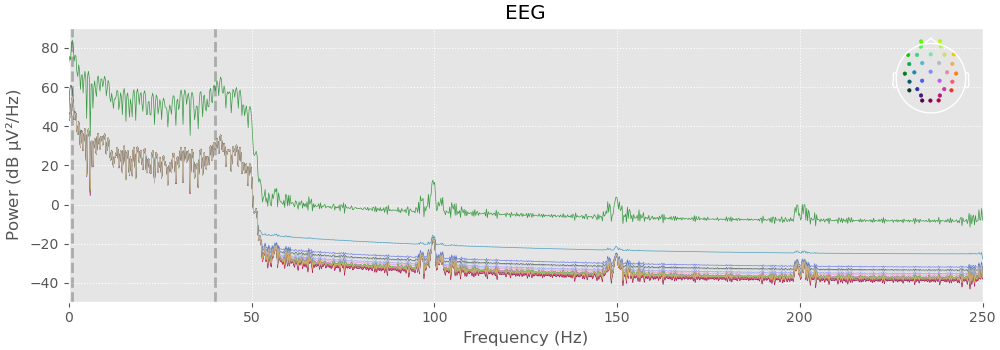

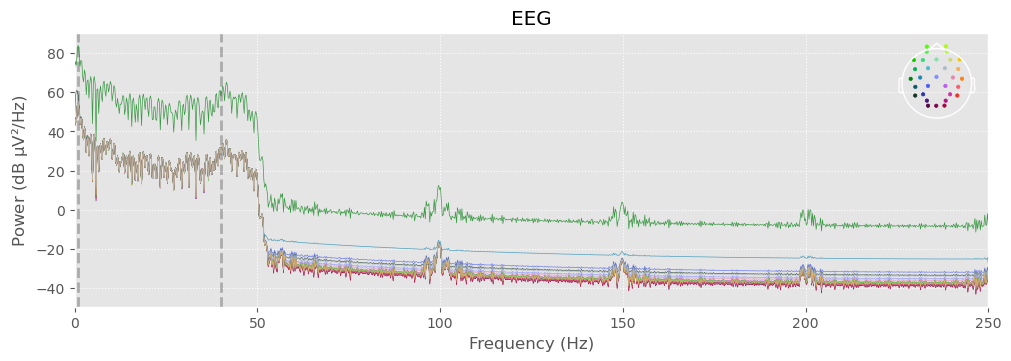

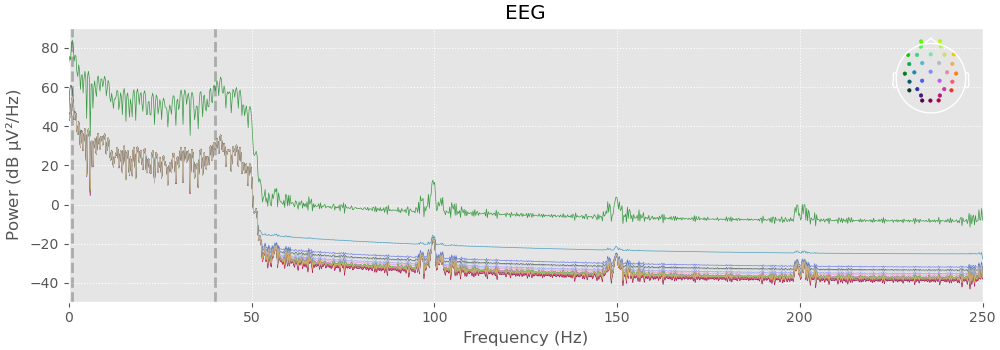

In [17]:
# Plot PSD of the baseline data
baseline_raw.compute_psd().plot()


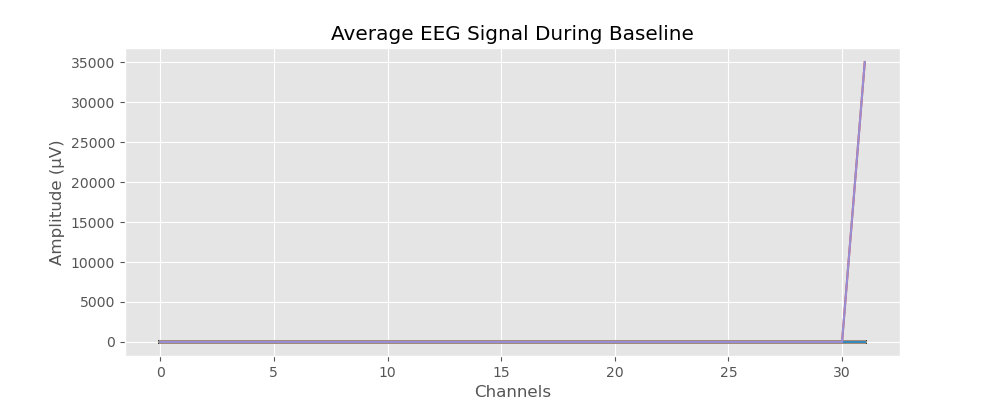

In [18]:
# Average across time
baseline_data = baseline_raw.get_data()
baseline_mean = np.mean(baseline_data, axis=1)

# Plot the average EEG signal
plt.figure(figsize=(10, 4))
plt.plot(baseline_data)
plt.title('Average EEG Signal During Baseline')
plt.xlabel('Channels')
plt.ylabel('Amplitude (µV)')
plt.show()


In [ ]:
# Determine the time of the end of baseline
if len(baseline_events) == 2:
    tmin_post = baseline_events[1, 0] / raw.info['sfreq']
    tmax_post = raw.times[-1]
    post_baseline_raw = raw.copy().crop(tmin=tmin_post, tmax=tmax_post)
else:
    print("Cannot extract post-baseline data.")

# Plot PSD of the post-baseline data
post_baseline_raw.compute_psd().plot();


In [ ]:
# Compute PSD for baseline
psd_baseline = baseline_raw.compute_psd(method='welch', fmin=1, fmax=40, n_fft=2048)
psds_baseline = psd_baseline.get_data()
freqs_baseline = psd_baseline.freqs

# Compute PSD for post-baseline
psd_post = post_baseline_raw.compute_psd(method='welch', fmin=1, fmax=40, n_fft=2048)
psds_post = psd_post.get_data()
freqs_post = psd_post.freqs



In [ ]:
# Define frequency bands
freq_bands = {'theta': [4, 7],
              'alpha': [8, 13],
              'beta': [13, 30]}


In [ ]:
band_powers_baseline = {}
for band_name, freq_range in freq_bands.items():
    fmin, fmax = freq_range
    freq_mask = (freqs_baseline >= fmin) & (freqs_baseline <= fmax)
    band_power = psds_baseline[:, freq_mask].mean(axis=1)
    band_powers_baseline[band_name] = band_power

band_powers_post = {}
for band_name, freq_range in freq_bands.items():
    fmin, fmax = freq_range
    freq_mask = (freqs_post >= fmin) & (freqs_post <= fmax)
    band_power = psds_post[:, freq_mask].mean(axis=1)
    band_powers_post[band_name] = band_power

percent_change = {}
for band_name in freq_bands.keys():
    freqs_bl = band_powers_baseline[band_name]
    freqs_post = band_powers_post[band_name]
    percent_change[band_name] = ((freqs_post - freqs_bl) / freqs_bl) * 100


In [ ]:
clusters = {
    'faa': ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz', 'AF3', 'AF4', 'FC1', 'FC5', 'FC6', 'FC2'],
    'fmt': ['Fz', 'Cz', 'Pz'],
    'left_faa': ['Fp1', 'F3', 'F7', 'AF3', 'FC1', 'FC5'],
    'right_faa': ['Fp2', 'F4', 'F8', 'AF4', 'FC2', 'FC6'],
    'midline': ['Fz', 'Cz', 'Pz']
}

# Function to get channel indices
def get_channel_indices(raw, ch_names):
    indices = []
    for ch_name in ch_names:
        if ch_name in raw.ch_names:
            indices.append(raw.ch_names.index(ch_name))
    return indices

# Get indices for clusters
frontal_indices = get_channel_indices(raw, clusters['faa'])
fmt_indices = get_channel_indices(raw, clusters['midline'])
left_faa_indices = get_channel_indices(raw, clusters['left_faa'])
right_faa_indices = get_channel_indices(raw, clusters['right_faa'])


In [ ]:
bands = ['theta', 'alpha', 'beta']
n_bands = len(bands)
n_channels = psds_baseline.shape[0]
percent_change_array = np.zeros((n_channels, n_bands))

for i, band_name in enumerate(bands):
    percent_change_array[:, i] = percent_change[band_name]



In [ ]:
from scipy import stats

# Get alpha percent change for frontal channels
fa_values = percent_change_array[frontal_indices, 1]

# Compute mean and 95% CI
fa_mean = np.mean(fa_values)
fa_se = stats.sem(fa_values)
fa_ci = fa_se * 1.96  # 95% CI

print("Frontal Alpha Power (FA):", fa_mean)

# Get theta percent change for midline channels
fmt_values = percent_change_array[fmt_indices, 0]

# Compute mean and 95% CI
fmt_mean = np.mean(fmt_values)
fmt_se = stats.sem(fmt_values)
fmt_ci = fmt_se * 1.96  # 95% CI

print("Frontal Midline Theta (FMT):", fmt_mean)

# Get theta and beta percent changes for frontal channels
theta_values = percent_change_array[frontal_indices, 0]
beta_values = percent_change_array[frontal_indices, 2]

# Compute TBR per channel
tbr_values = theta_values / beta_values

# Compute mean and 95% CI
tbr_mean = np.mean(tbr_values)
tbr_se = stats.sem(tbr_values)
tbr_ci = tbr_se * 1.96  # 95% CI

print("Theta-Beta Ratio (TBR):", tbr_mean)

# Get alpha power for left and right channels from post-baseline data
left_alpha_values = band_powers_post['alpha'][left_faa_indices]
right_alpha_values = band_powers_post['alpha'][right_faa_indices]

# Ensure arrays are of the same length
min_length = min(len(left_alpha_values), len(right_alpha_values))
left_alpha_values = left_alpha_values[:min_length]
right_alpha_values = right_alpha_values[:min_length]

# Compute FAA per channel pair
faa_values = np.log(left_alpha_values) - np.log(right_alpha_values)

# Compute mean and 95% CI
faa_mean = np.mean(faa_values)
faa_se = stats.sem(faa_values)
faa_ci = faa_se * 1.96  # 95% CI

print("Frontal Alpha Asymmetry (FAA):", faa_mean)




In [ ]:
fa_values

In [ ]:
# Prepare data for plotting
features = ['FA', 'FMT', 'TBR', 'FAA']
means = [fa_mean, fmt_mean, tbr_mean, faa_mean]
cis = [fa_ci, fmt_ci, tbr_ci, faa_ci]

# Plot the bar plots with error bars
plt.figure(figsize=(8, 6))
bars = plt.bar(features, means, yerr=cis, capsize=10, color='skyblue', alpha=0.7)
plt.ylabel('Value')
plt.title('Frequency Features with 95% Confidence Intervals')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Determine the shortest data length
len_baseline = len(baseline_raw.times)
len_post = len(post_baseline_raw.times)
min_length = min(len_baseline, len_post)

# Set n_per_seg and n_fft based on minimum length
n_per_seg = min(256, min_length // 8)  # Adjust as needed
n_overlap = n_per_seg // 2  # 50% overlap
n_fft = max(256, n_per_seg)

# Compute PSD for baseline
psd_baseline = baseline_raw.compute_psd(
    method='welch',
    fmin=1,
    fmax=40,
    n_fft=n_fft,
    n_per_seg=n_per_seg,
    n_overlap=n_overlap
)
psds_baseline = psd_baseline.get_data()
freqs_baseline = psd_baseline.freqs

# Compute PSD for post-baseline
psd_post = post_baseline_raw.compute_psd(
    method='welch',
    fmin=1,
    fmax=40,
    n_fft=n_fft,
    n_per_seg=n_per_seg,
    n_overlap=n_overlap
)
psds_post = psd_post.get_data()
freqs_post = psd_post.freqs

# Verify that frequencies match
if np.array_equal(freqs_baseline, freqs_post):
    print("Frequency arrays match.")
else:
    print("Frequency arrays do not match.")
    # Optionally, interpolate or adjust further

# Compute mean PSD across channels
mean_psd_baseline = psds_baseline.mean(axis=0)
mean_psd_post = psds_post.mean(axis=0)

# Plot the PSDs
plt.figure(figsize=(10, 6))
plt.semilogy(freqs_baseline, mean_psd_baseline, label='Baseline')
plt.semilogy(freqs_post, mean_psd_post, label='Post-Baseline')
plt.title('Average Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.show()


# Correlations

# Data stream synchronization

In [ ]:
# plot_traces({
#     'GSR (µS)': datapicker.dataset.streams.Empatica.data.E4_Gsr['Value'],
#     # 'HR (bpm)': datapicker.dataset.streams.Empatica.data.E4_Hr['Value'],
#     'BVP (a.u.)': datapicker.dataset.streams.Empatica.data.E4_Bvp['Value'],
#     # 'IBI (ms)': datapicker.dataset.streams.Empatica.data.E4_Ibi['Value'],
#     'T (°C)': datapicker.dataset.streams.Empatica.data.E4_Temperature['Value'],
#     # 'Battery (%)': datapicker.dataset.streams.Empatica.data.E4_Battery['Value'],
#     'EEG (\u03BCV)': raw,    
#     'ECG (\u03BCV)': datapicker.dataset.streams.BioData.ECG.data['Value0'],
#     }, 
#     # segments = chk_segments,
#     figsize=(10, 10)
#     )